In [14]:
import numpy as np
import numpy.random as rnd

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch import FloatTensor, IntTensor, LongTensor

from  torch.utils.data import TensorDataset, DataLoader, ConcatDataset

import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

#### Все места, где нужно дописать код отмечены TODO.

## Считывание и подготовка данных.

In [2]:
# Считываем данные: каждый класс лежит в своем csv файле. 
male = pd.read_csv('male.csv',header = None)[0]
female = pd.read_csv('female.csv',header = None)[0]

y = np.hstack((np.zeros(len(male)),np.ones(len(female))))
data = list(male)
data.extend(list(female))

In [3]:
# Для дальнейшей работы нам понадобится словарь символов + 
# мы не будем различать строчные и прописные буквы + 
# у нас все последовательности разной длины и нам нужно понимать, какова макимальная длина + 
# нам нужен отдельный символ под паддинг, чтобы уметь работать с последовательностями разной длины
MAX_LEN = 0
chars = set()
for i in range(len(data)):
    data[i] = data[i].lower()
    MAX_LEN = max(MAX_LEN,len(data[i]))
    chars = chars.union(set(data[i][:]))
    
chars = list(chars)
PAD_CHAR = '_PADDING_'
chars = [PAD_CHAR] + sorted(chars)
char_to_id = { ch:id for id,ch in enumerate(chars) }
id_to_char = { id:ch for id,ch in enumerate(chars) }

VOCAB_SIZE = len(chars)

In [4]:
# Разделим выборку на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

In [25]:
def data2format(data, labels):
    """Функция преобразует выбоку данных в формат, подходящий для подачи в нейронную сеть.
    
    data - список строк (пример - X_train)
    labels - вектор меток для строк из data (пример - y_train)
    
    Дальше за N обозначается число строк в data
    
    Вернуть нужно словарь со следующими элементами:
    x - матрица размера [N, MAX_LEN], в которой каждая строка соответствует строке в data:
        вся строка кодируется с помощью char_to_id, недостающие элементы в конце коротких строк заполняются символом PAD_CHAR
    y - вектор длины N с метками
    
    """
    X = []
    for row in data:
        char_id = []
        char_id = [char_to_id[x] for x in row]
        char_id += [char_to_id[PAD_CHAR]] * (MAX_LEN - len(char_id))
        X.append(char_id)
    return {'x':np.array(X), 'y':labels}

In [26]:
train_data = data2format(X_train,y_train)
test_data = data2format(X_test,y_test)

In [27]:
# Необходимые константы
NUM_EPOCHS = 20
BATCH_SIZE = 50
SEQ_LEN = 20
LEARNING_RATE = 0.01
GRAD_CLIP = 100

## Вспомогательные функции

In [28]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(train_err, train_acc, test_err, test_acc, network):
    return {'train_err':train_err, 
        'train_acc':train_acc, 
        'test_err':test_err, 
        'test_acc':test_acc, 
        'network':network
           } 

# устойчивая реализация кросс-энтропии
def BinaryCrossentropy(probs, labels):
    probs = probs[:, 0]
    probs = torch.clamp(probs, 1e-7, 1-1e-7)
    labels = labels.type(probs.data.type())
    return -(labels * torch.log(probs) + (1 - labels) * (torch.log(1 - probs))).mean()

## Нейронная сеть

В простейшем случае мы будем использовать сеть, которая считывает входную последовательность, и выдает результат только в самом конце.

In [29]:
def create_variable(tensor):
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def pad_sequences(names, genders):
    seq_tensor = names[:,:-1]
    lengths = names[:,-1]
    lengths, perm_idx = lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]

    if len(genders):
        genders = genders[perm_idx]

    return create_variable(seq_tensor), \
        create_variable(lengths), \
        create_variable(genders)

In [45]:
def create_output(outputs, lengths):
    result = [out[lengths[i] - 1] for i, out in enumerate(outputs)]
    return orch.stack(result)

In [30]:
# Для работы с последовательностями разной длины стоит использовать эти функции.
# Обратите внимание, что последователньости нужно отсортировать перед подачей в pack_padded_sequence.
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Net(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, MAX_LEN] 
    и применяет к нему следующие преобразования:
    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое. Из этого слоя нам нужно только выход в последний момент времени.
    3. Полносвязный слой для бинарной классификации с sigmoid в качестве нелинейности.
    
    * Обратите внимание на параметр batch_first у рекуррентного слоя.
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size):
        super(Net, self).__init__()          
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, 1, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid

    def forward(self, names, lengths):
        enc = self.encoder(names)
        out = pack_padded_sequence(enc, lengths, batch_first=True)
        out, hidden = self.rnn(out)
        outputs, _ = pad_packed_sequence(out, batch_first=True)
        out = create_output(outputs, lengths)
        dec = self.decoder(out)
        return self.sigmoid(dec)

In [31]:
def acc(out, target):
    out    = out.data.numpy().astype(int)
    target = target.data.numpy().astype(int)
    return accuracy_score(out, target)

In [78]:
def prepare_for_pad(data, labels):
    result = np.column_stack((data, labels))
    result = np.column_stack((result, np.count_nonzero(batch_data, axis=1)))
    result = result[(-1 * sort_data[:, MAX_LEN + 1]).argsort()]
    return (result[:, :MAX_LEN], result[:, MAX_LEN])

In [70]:
def train(train_data, test_data, emb_size, n_hidden, show = False):
    """Функция обучает нейросеть по данным train_data + контролирует процесс по качеству на test_data
    Следует обратить внимание на следующее:
    1. Сеть будем учить NUM_EPOCHS эпох, в каждой из столько батчей, сколько есть в train_data
    2. Генерировать батчи можно с помощью батчгенератора pytorch. Для этого пригодятся torch.utils.data.TensorDataset
        и torch.utils.data.DataLoader.
    3. Для того, чтобы следить за процессом обучения будем считать средний loss и 
        среднюю точность классификации на всех батчах трейна и теста и сохранять эти данные 
        в соответствующие массивы. 
    4. Перед тем, как делать шаг по градиенту, будем ограничивать градиент по норме значением GRAD_CLIP
    
    """
    print("Prepare data ...")
    
    train_tensordataset = TensorDataset(data_tensor=LongTensor(train_data['x'].tolist()),
                                        target_tensor=LongTensor(train_data['y'].astype(int).tolist()))    
    test_tensordataset  = TensorDataset(data_tensor=LongTensor(test_data['x'].tolist()),
                                        target_tensor=LongTensor(test_data['y'].astype(int).tolist()))   
    
    train_loader = DataLoader(train_tensordataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_tensordataset, batch_size=BATCH_SIZE, shuffle=True)

    train_size = len(train_data['x'])
    test_size = len(test_data['x'])
    num_train_batches = train_size / BATCH_SIZE
    num_test_batches = test_size / BATCH_SIZE
    train_err=np.zeros(NUM_EPOCHS)
    train_acc=np.zeros(NUM_EPOCHS)
    test_err=np.zeros(NUM_EPOCHS)
    test_acc=np.zeros(NUM_EPOCHS)

    print("Building network ...")
    net = Net(emb_size, n_hidden, VOCAB_SIZE, BATCH_SIZE)
    net.train()
    print("The network has {} params".format(sum([x.data.numel() for x in net.parameters()])))
    
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    print("Training ...")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()            
        for i, batch in enumerate(train_loader):                     
            
            data, labels = batch[0], batch[1]
            batch_data, label_data = prepare_for_pad(data, labels)
            lengths = np.count_nonzero(data, axis=1)
            net.zero_grad()
            
            data = Variable(torch.LongTensor(data))
            labels = Variable(torch.LongTensor(labels))      
            out = net(data, lengths)
            
            loss = BinaryCrossentropy(output, label_data)
            loss.backward()
            
            nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
            optimizer.step()
            train_err[epoch] += loss
            train_acc[epoch] += acc(out, labels)   
            
        for i, batch in enumerate(test_loader):          
            data, labels = batch[0], batch[1]
            batch_data, label_data = prepare_for_pad(data, labels)
            lengths = np.count_nonzero(data, axis=1)
            net.zero_grad()
            
            data = Variable(torch.LongTensor(data))
            labels = Variable(torch.LongTensor(labels))      
            out = net(data, lengths)
            
            loss = BinaryCrossentropy(output, label_data)
            loss.backward()
            
            nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
            optimizer.step()
            train_err[epoch] += loss
            train_acc[epoch] += acc(out, labels)   
            
        train_err[epoch] /= num_train_batches
        train_acc[epoch] /= num_train_batches
        test_err[epoch] /=  num_test_batches
        test_acc[epoch] /=  num_test_batches
    
        print("Epoch {} \t loss / accuracy test = {:.4f}, {:.4f} \t train = {:.4f}, {:.4f} \t time = {:.2f}s".
              format(epoch, test_err[epoch],test_acc[epoch], 
                     train_err[epoch],  train_acc[epoch],time.time() - start_time))
             
    return pack(train_err, train_acc, test_err, test_acc, net)

Перед тем, как запускать обучение большой сети на большое число эпох, проверьте, что маленькая сеть выдает вменяемые результаты: качество больше 50%.

In [33]:
model = train(train_data, test_data, 40, 100)

Prepare data ...
Building network ...
The network has 15501 params
Training ...
Epoch 0 	 loss / accuracy test = 0.4416, 0.7821 	 train = 0.4894, 0.7592 	 time = 2.05s
Epoch 1 	 loss / accuracy test = 0.4392, 0.8014 	 train = 0.4471, 0.7890 	 time = 1.95s
Epoch 2 	 loss / accuracy test = 0.4086, 0.8077 	 train = 0.4035, 0.8171 	 time = 2.01s
Epoch 3 	 loss / accuracy test = 0.3868, 0.8285 	 train = 0.3586, 0.8423 	 time = 1.96s
Epoch 4 	 loss / accuracy test = 0.3981, 0.8224 	 train = 0.3231, 0.8673 	 time = 1.97s
Epoch 5 	 loss / accuracy test = 0.3902, 0.8363 	 train = 0.2987, 0.8824 	 time = 1.97s
Epoch 6 	 loss / accuracy test = 0.3913, 0.8346 	 train = 0.2894, 0.8827 	 time = 1.97s
Epoch 7 	 loss / accuracy test = 0.3919, 0.8362 	 train = 0.2808, 0.8890 	 time = 1.92s
Epoch 8 	 loss / accuracy test = 0.3921, 0.8348 	 train = 0.2777, 0.8897 	 time = 1.92s
Epoch 9 	 loss / accuracy test = 0.3924, 0.8344 	 train = 0.2758, 0.8921 	 time = 1.90s
Epoch 10 	 loss / accuracy test = 0.3918

## Посмотрим что из этого вышло

In [41]:
def predict(name, model):
    """Функция выдает предсказание обученной модели model для имени name.
    Предсказание - число из [0,1] - вероятность того, что имя женское
    """
    data = np.ones((1, MAX_LEN), int) * char_to_id['_PADDING_']
    for i, ch in enumerate(list(name)):
        data[0, i] = char_to_id[ch]
    data = Variable(LongTensor(data))
    pred = model['network'](data, np.array([len(name)]))[:, 0].data.numpy()[0]
    return pred

In [42]:
dataset = set(data)

In [43]:
name = 'Yaroslav'.lower()
if name in dataset:
    print('This name is in our dataset')
else:
    print('This is a new name')
pred = predict(name, model)
print(pred)
if pred>=0.5:
    print("It's female name")
else:
    print("It's male name")
print(pred)

This is a new name
0.1696
It's male name
0.1696


In [44]:
name = 'Polina'.lower()
if name in dataset:
    print('This name is in our dataset')
else:
    print('This is a new name')
pred = predict(name, model)
if pred>=0.5:
    print("It's female name")
else:
    print("It's male name")
print(pred)

This is a new name
It's female name
0.9944


## Дополнительные пункты

1. Обучение более сложной модели и контроль переобучения. Попробуйте подобрать хорошую модель RNN для данной задачи. Для этого проанализируйте качество работы модели в зависимости от ее размеров, попробуйте использовать многослойную сеть. Также нужно проконтролировать переобучение моделей. Для этого можно выделить тестовый кусок из текста и смотреть на то, как меняется loss на нем в процессе обучения. Если на графиках видно переобучение, то стоит добавить dropout слои в модель (обычный dropout до, между и после рекуррентных слоев). При использовании дропаута на стадии предсказания для нового объекта нужно ставить флаг deterministic=True.
2. Другая архитектура 1. Попробуйте использовать не только состоянию скрытых переменных в последний момент времени, а усреднение/максимум значений скрытых переменных во все моменты времени. Попробуйте двунаправленную сеть при таком подходе. 
3. Другая архитектура 2. Попробуйте использовать не только состоянию скрытых переменных в последний момент времени, а сумму значений скрытых переменных во все моменты времени с коэффициентами attention. Попробуйте двунаправленную сеть при таком подходе. Attention коэффициент для определенного момента времени может представлять собой просто линейную комбинацию значений скрытых переменных в этот момент времени с обучаемыми весами.
3. Визуализация. Попробуйте провизуализировать результаты. Например, для стандартной архитектуры можно посмотреть на изменение предсказания во времени: на каких элементах предсказание значительнее всего изменяется в сторону одного или другого класса? При использовании схемы из 2/3 пункта, можно смотреть на вклад каждого момента времени в результат. Так как после рекуррентного слоя у нас стоит просто линейный классификатор, то можно посмотреть, что выдает этот классификатор при применении к скрытым переменным в каждый момент времени. Таким образом выделяться те буквы, которые голосуют за один класс и те, которые голосуют за другой.
4. Batchnorm и Layernorm. Запрограммируйте RNN c layer normalization из статьи [Lei Ba et al., 2016]. Поэкспериментируйте с применением обычной batch normalization и layer normalization, сравните результаты.

Рассмотрим 2-слойную LSTM с dropout

In [75]:
class Net(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size):
        super(Net, self).__init__()          
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid

    def forward(self, names, lengths):
        enc = self.encoder(names)
        out = pack_padded_sequence(enc, lengths, batch_first=True)
        out, (h, c) = self.lstm(out)
        outputs, _ = pad_packed_sequence(out, batch_first=True)
        out = create_output(outputs, lengths)
        dec = self.decoder(out)
        return self.sigmoid(dec)

In [76]:
model = train(train_data, test_data, 40, 100)

Prepare data ...
Building network ...
The network has 138901 params
Training ...
Epoch 0 	 loss / accuracy test = 0.4254, 0.8067 	 train = 0.4754, 0.7658 	 time = 4.71s
Epoch 1 	 loss / accuracy test = 0.3989, 0.8119 	 train = 0.4126, 0.8117 	 time = 4.64s
Epoch 2 	 loss / accuracy test = 0.3878, 0.8230 	 train = 0.3558, 0.8462 	 time = 4.78s
Epoch 3 	 loss / accuracy test = 0.3911, 0.8249 	 train = 0.2987, 0.8727 	 time = 4.92s
Epoch 4 	 loss / accuracy test = 0.4056, 0.8212 	 train = 0.2569, 0.8935 	 time = 4.82s
Epoch 5 	 loss / accuracy test = 0.4200, 0.8210 	 train = 0.2312, 0.9065 	 time = 4.94s
Epoch 6 	 loss / accuracy test = 0.4281, 0.8230 	 train = 0.2216, 0.9121 	 time = 4.84s
Epoch 7 	 loss / accuracy test = 0.4352, 0.8238 	 train = 0.2092, 0.9165 	 time = 4.99s
Epoch 8 	 loss / accuracy test = 0.4360, 0.8243 	 train = 0.2053, 0.9174 	 time = 5.07s
Epoch 9 	 loss / accuracy test = 0.4366, 0.8252 	 train = 0.2032, 0.9180 	 time = 4.93s
Epoch 10 	 loss / accuracy test = 0.439

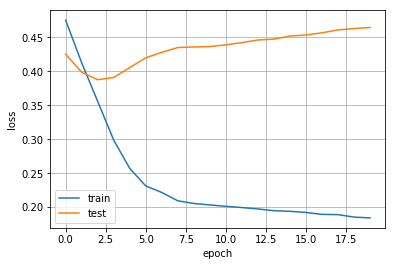

In [83]:
import matplotlib.pyplot as plt
plt.plot(model['train_err'], label='train')
plt.plot(model['test_err'], label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

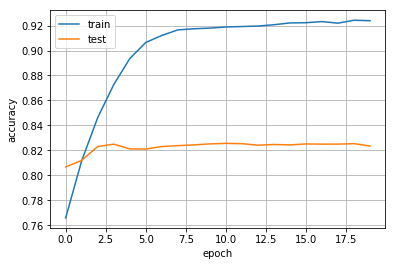

In [84]:
plt.plot(model['train_acc'], label='train')
plt.plot(model['test_acc'], label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

Даже с добавлением dropout'а LSTM переобучается, возможно два слоя в этой задаче слишком много.